# Проект - Молочная ферма

## Описание проекта

В настоящем проекте мы будем исследовать данные о производительности молочной фермы и качестве ее продукции, выраженной эмпирическим показателем на базе отзывов потребителя.

**Цель исследования:** формирование рекомендаций Заказчику по подбору животных при покупке дополнительного поголовья.

В процессе исследования мы будем обучать модели линейной и логистической регрессии, а также оптимизировать их для достижения качества результатов прогнозирования в соответствии с требованиями Заказчика.

Для работы над проектом мы будем использовать следующие наборы данных:
- Информация о характеристиках текущего поголовья Заказчика, объема и качества выпускаемой продукции, данные о содержании питательных веществ в кормах
- Данные о генетической наследственности текущего поголовья
- Сведения о доступных к приобретению животных

План работ по релизации проекта:
1. Загрузка исходных данных в датафреймы Pandas
2. Предобработка данных, а именно:
    * устранение пропусков и нулевых значений
    * устранение явных и неявных дубликатов
    * приведение данных к правильным форматам
3. Исследовательский анализ данных, в том числе:
    * построение гистограмм и диаграмм размаха для количественных признаков
    * построение круговых диаграмм для качественных признаков
    * анализ и устранение выбросов и других аномалий в данных
4. Корреляционный анализ данных
    * построение матрицы корреляции
    * построение диаграмм рассеяния
    * анализ наличия зависимостей между входными признаками
    * проверка наличия линейной связи входных признаков с целевым
4. Прогнозирование производительности предлагаемых к покупке животных при помощи модели линейной регрессии:
    * подготовка данных для обучения модели
    * обучение модели и получение предсказаний
    * вычисление метрик качества модели
    * оптимизация модели путем добавления новых признаков или трансформации существующих признаков
    * подбор итогового варианта модели и получение предсказаний
5. Прогнозирование качества продукции предлагаемых к покупке животных при помощи модели логистической регрессии:
    * подготовка данных для обучения модели
    * обучение модели и получение предсказаний
    * вычисление метрик качества модели
    * оптимизация модели путем добавления новых признаков или трансформации существующих признаков
    * подбор итогового варианта модели и получение предсказаний
6. Формирование итоговых рекомендаций Заказчику

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import sklearn
RANDOM_STATE = 74
TARGET_OUTPUT = 6000
TARGET_TASTE = 'вкусно'

In [2]:
farm = pd.read_csv('/datasets/ferma_main.csv', sep=';')
legacy = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
shop = pd.read_csv('/datasets/cow_buy.csv', sep=';')

##  Предобработка данных

Определим функцию для автоматического анализа информации о датасете, наличия нулевых значений в данных, пропусков и явных дубликатов:

In [3]:
def data_report(df, show_info=True):
    temp = df.copy() 
    col_list = temp.columns
    print('='* 90)
    if show_info == True:
        print(temp.info())
#Поиск нулевых значений
    counter = 0
    for column in col_list:
        if temp[temp[column] == 0][column].count() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с нулевыми значениями: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с нулевыми значениями:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во нулевых значений":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[temp[column] == 0][column].count() > 0:
                print(f'{column :<40}'
                      f'{temp[temp[column] == 0][column].count():<25}'
                      f'{temp[temp[column] == 0][column].count()/len(temp):.2%}')                
#Поиск пропусков
    counter = 0
    for column in col_list:
        if temp[column].isna().sum() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пропусками: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пропусками:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во пропусков":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[temp[column] == 0][column].count() > 0:
                print(f'{column :<40}'
                      f'{temp[column].isna().sum():<25}'
                      f'{temp[column].isna().mean():.2%}')                
#Поиск явных дубликатов
    duplicates = temp.duplicated().sum()
    print('-'* 90)
    print(f'Количество дубликатов по строкам: {duplicates}')
    print('-'* 90)
    if duplicates > 0:
        print('Дублированные строки:')
        print('-'* 90)
        print(temp[temp.duplicated()==True][col_list[:3]])
        print('='* 90)

Последовательно применим эту функцию ко всем датасетам, находящимися в обработке.

In [4]:
data_report(farm)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

In [5]:
data_report(shop)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB
None
------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
--------------------------------------------

In [6]:
data_report(legacy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None
------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
------------------------------------------------------------------------------------------


Устраним обнаруженные явные дубликаты:

In [7]:
farm = farm.drop_duplicates().reset_index(drop=True)
farm.duplicated().sum()

0

In [8]:
shop = shop.drop_duplicates().reset_index(drop=True)
shop.duplicated().sum()

0

Переименуем колонки в латинские названия строчными буквами:

In [9]:
farm = farm.rename(columns=
            {'Удой, кг': 'milk_output',
             'ЭКЕ (Энергетическая кормовая единица)': 'meal_energy',
             'Сырой протеин, г': 'meal_protein',
             'СПО (Сахаро-протеиновое соотношение)': 'meal_gpr',
             'Порода': 'race',
             'Тип пастбища': 'pasture_type',
             'порода папы_быка': 'dad_race',
             'Жирность,%': 'milk_fat',
             'Белок,%': 'milk_protein',
             'Вкус молока': 'milk_taste',
             'Возраст': 'age_category'})

In [10]:
shop = shop.rename(columns=
            {'Порода': 'race',
             'Тип пастбища': 'pasture_type',
             'порода папы_быка': 'dad_race',
             'Текущая_жирность,%': 'milk_fat',
             'Текущий_уровень_белок,%': 'milk_protein',
             'Имя_папы': 'dad_name',
             'Возраст': 'age_category'})

In [11]:
legacy = legacy.rename(columns={'Имя Папы': 'dad_name'})

Создадим словарь для возможности читабельного отображения названий новых полей на графиках

In [12]:
glossary = {
    'milk_output': 'Удой за год (кг)',
    'meal_energy': 'ЭКЕ корма (Энергетическая Кормовая Единица)',
    'meal_protein': 'Сырой протеин в корме (г)',
    'meal_gpr': 'СПО корма (Сахаро-протеиновое соотношение)',
    'race': 'Порода коровы',
    'pasture_type': 'Тип пастбища',
    'dad_race': 'Порода производителя',
    'milk_fat': 'Жирность молока (%)',
    'milk_protein': 'Содержание белка в молоке (%)',
    'milk_taste': 'Вкус молока',
    'age_category': 'Категория возраста',
    'dad_name': 'Имя производителя',
}

В данных было обнаружено несоотвествие символа-разделителя целой и дробной части, в связи с чем невозможно было привести данные к правильному формату.\
Создадим функцию для поиска и массовой замены значений в колонках датафрейма.

In [13]:
def replace(df, columns, old_value, new_value):
    for column in columns:
        for i in df[column].index:
            try:
                df[column].loc[i] = df[column].loc[i].replace(old_value, new_value)
            except:
                continue

Заменим некорректные значения в датафрейме при помощи этой функции

In [14]:
#%%capture --no-stdout
warnings.filterwarnings('ignore')
replace(farm, ['meal_energy', 'meal_gpr', 'milk_fat', 'milk_protein'], ',', '.')
replace(shop, ['milk_fat', 'milk_protein'], ',', '.')

Приведем данные к правильным форматам

In [15]:
farm['meal_energy'] = pd.to_numeric(farm['meal_energy'], errors='coerce').astype('float32')
farm['meal_gpr'] = pd.to_numeric(farm['meal_gpr'], errors='coerce').astype('float32')
farm['milk_fat'] = pd.to_numeric(farm['milk_fat'], errors='coerce').astype('float32')
farm['milk_protein'] = pd.to_numeric(farm['milk_protein'], errors='coerce').astype('float32')
farm['id'] = farm['id'].astype('int32')
farm['milk_output'] = farm['milk_output'].astype('int32')
shop['milk_fat'] = pd.to_numeric(shop['milk_fat'], errors='coerce').astype('float32')
shop['milk_protein'] = pd.to_numeric(shop['milk_protein'], errors='coerce').astype('float32')

Сформируем контрольный отчет о состоянии данных по всем датафреймам

In [16]:
display(data_report(farm, show_info=False))
display(data_report(shop, show_info=False))
data_report(legacy, show_info=False)

------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
------------------------------------------------------------------------------------------


None

------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
------------------------------------------------------------------------------------------


None

------------------------------------------------------------------------------------------
Столбцов с нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
------------------------------------------------------------------------------------------


Создадим функцию для визуального поиска неявных дубликатов

In [17]:
def check_duplicates(df, columns):
    for col in columns:
        print(f'{col:<20} - {df[col].unique()}')
        print('-'*100)

Изучим датасет на наличие неявных дубликатов

In [18]:
check_duplicates(farm, ['race', 'pasture_type', 'dad_race', 'milk_taste', 'age_category'])

race                 - ['Вис Бик Айдиал' 'РефлешнСоверинг']
----------------------------------------------------------------------------------------------------
pasture_type         - ['Равнинное' 'Равнинные' 'Холмистое']
----------------------------------------------------------------------------------------------------
dad_race             - ['Айдиал' 'Соверин' 'Айдиалл']
----------------------------------------------------------------------------------------------------
milk_taste           - ['вкусно' 'не вкусно']
----------------------------------------------------------------------------------------------------
age_category         - ['более_2_лет' 'менее_2_лет']
----------------------------------------------------------------------------------------------------


In [19]:
check_duplicates(shop, ['race', 'pasture_type', 'dad_race', 'dad_name', 'age_category'])

race                 - ['Вис Бик Айдиал' 'РефлешнСоверинг']
----------------------------------------------------------------------------------------------------
pasture_type         - ['холмистое' 'равнинное']
----------------------------------------------------------------------------------------------------
dad_race             - ['Айдиал' 'Соверин']
----------------------------------------------------------------------------------------------------
dad_name             - ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
----------------------------------------------------------------------------------------------------
age_category         - ['более_2_лет' 'менее_2_лет']
----------------------------------------------------------------------------------------------------


In [20]:
check_duplicates(legacy, ['dad_name'])

dad_name             - ['Буйный' 'Соловчик' 'Барин' 'Геркулес']
----------------------------------------------------------------------------------------------------


Устраним обнаруженные неявные дуликаты в данных

In [21]:
farm['pasture_type'] = farm['pasture_type'].replace('Равнинные', 'Равнинное')
farm['dad_race'] = farm['dad_race'].replace({'Айдиал': 'Вис Бэк Айдиал', 'Айдиалл': 'Вис Бэк Айдиал', 'Соверин': 'Рефлекшн Соверинг'})
farm['race'] = farm['race'].replace({'Вис Бик Айдиал': 'Вис Бэк Айдиал', 'РефлешнСоверинг': 'Рефлекшн Соверинг'})
shop['pasture_type'] = shop['pasture_type'].replace({'равнинное': 'Равнинное', 'холмистое': 'Холмистое'})
shop['race'] = shop['race'].replace({'Вис Бик Айдиал': 'Вис Бэк Айдиал', 'РефлешнСоверинг': 'Рефлекшн Соверинг'})
shop['dad_race'] = shop['dad_race'].replace({'Айдиал': 'Вис Бэк Айдиал', 'Соверин': 'Рефлекшн Соверинг'})

Выведем проверочный отчет по неявным дубликатам

In [22]:
check_duplicates(farm, ['race', 'pasture_type', 'dad_race', 'milk_taste', 'age_category'])

race                 - ['Вис Бэк Айдиал' 'Рефлекшн Соверинг']
----------------------------------------------------------------------------------------------------
pasture_type         - ['Равнинное' 'Холмистое']
----------------------------------------------------------------------------------------------------
dad_race             - ['Вис Бэк Айдиал' 'Рефлекшн Соверинг']
----------------------------------------------------------------------------------------------------
milk_taste           - ['вкусно' 'не вкусно']
----------------------------------------------------------------------------------------------------
age_category         - ['более_2_лет' 'менее_2_лет']
----------------------------------------------------------------------------------------------------


In [23]:
check_duplicates(shop, ['race', 'pasture_type', 'dad_race', 'dad_name', 'age_category'])

race                 - ['Вис Бэк Айдиал' 'Рефлекшн Соверинг']
----------------------------------------------------------------------------------------------------
pasture_type         - ['Холмистое' 'Равнинное']
----------------------------------------------------------------------------------------------------
dad_race             - ['Вис Бэк Айдиал' 'Рефлекшн Соверинг']
----------------------------------------------------------------------------------------------------
dad_name             - ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
----------------------------------------------------------------------------------------------------
age_category         - ['более_2_лет' 'менее_2_лет']
----------------------------------------------------------------------------------------------------


### Вывод по этапу предобработки данных:
Данные в хорошем состоянии, отсутствуют пропуски и нулевые значения.\
Замечено незначительное количество явных дубликатов по строкам, которые были устранены.\
Обнаружено несоответствие формата данных в полях с с числовыми показателями, выраженными вещественными числами. Похоже, что причиной этому стал использумый в исходных данных разделитель целой и дробной части числа, который несовместим с форматом данных Python. Разделитель был заменен на соответствующий, все данные приведены к правильным форматам.\
Во всех таблицах обнаружено разнообразие наименований пород скота, которое было приведено к единому стандарту.

## Исследовательский анализ данных

Проведем статистический анализ всех признаков.\
Для этого создадим функцию и построим с ее помощью гистограммы распределения и диаграммы размаха для количественных признаков, и круговые диаграммы для категориальных признаков.

In [24]:
def stat_plots(indicator, nbins=10):
    if indicator.dtype in ['int32', 'int64', 'float32', 'float64']:
        title1 = 'Гистограмма распределения'
        title2 = 'Диаграмма размаха'
        ind_label = glossary[indicator.name]
        print('=' * 110)
        print(f'Статистический анализ показателя \033[1m {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        bins = axes[0].hist(indicator, bins=nbins)
        axes[0].vlines(x=indicator.mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=indicator.median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title(title1)
        axes[0].set_xlabel(ind_label)
        axes[0].legend()
        axes[1].boxplot(indicator, vert=False)
        axes[1].set_title(title2)
        axes[1].set_xlabel(ind_label)
        plt.show()
    else:
        ind_label = glossary[indicator.name]
        print('=' * 110)
        print(f'Распределение долей по показателю \033[1m {ind_label}')
        print('-' * 110)
        indicator.value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.show()    

**Исследуем количественные признаки**

Статистический анализ показателя  Удой за год (кг)
--------------------------------------------------------------------------------------------------------------


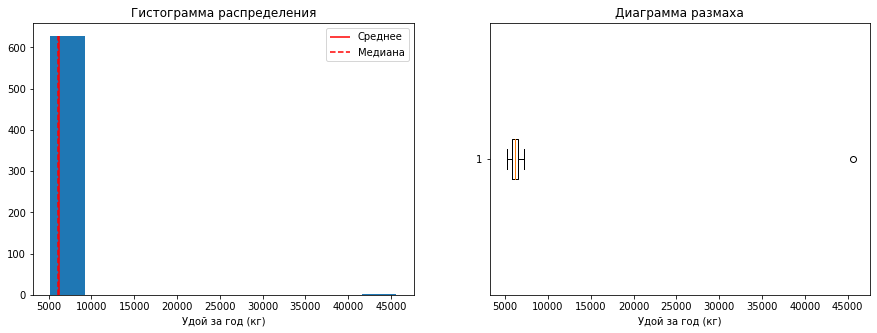

In [25]:
stat_plots(farm['milk_output'])

Распределение удоев показывает аномальный выброс - исследуем его и устраним:

In [26]:
farm[farm['milk_output'] == farm['milk_output'].max()]

,id,milk_output,meal_energy,meal_protein,meal_gpr,race,pasture_type,dad_race,milk_fat,milk_protein,milk_taste,age_category
16,17,45616,11.5,1675,0.93,Вис Бэк Айдиал,Холмистое,Вис Бэк Айдиал,3.22,3.076,вкусно,более_2_лет


In [27]:
farm[farm['race'] == 'Вис Бэк Айдиал']['milk_output'].describe()

count      373.000000
mean      6205.348525
std       2097.569359
min       5242.000000
25%       5716.000000
50%       6112.000000
75%       6469.000000
max      45616.000000
Name: milk_output, dtype: float64

In [28]:
farm.loc[16, 'milk_output'] = 5616

Повторно сформируем графики по этому признаку:

Статистический анализ показателя  Удой за год (кг)
--------------------------------------------------------------------------------------------------------------


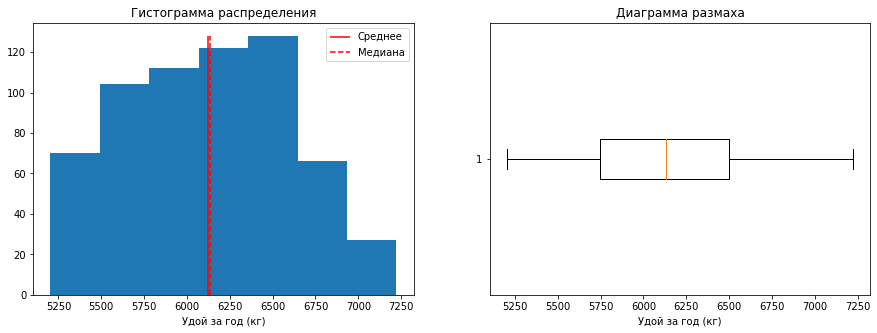

In [29]:
stat_plots(farm['milk_output'], nbins=7)

Статистический анализ показателя  ЭКЕ корма (Энергетическая Кормовая Единица)
--------------------------------------------------------------------------------------------------------------


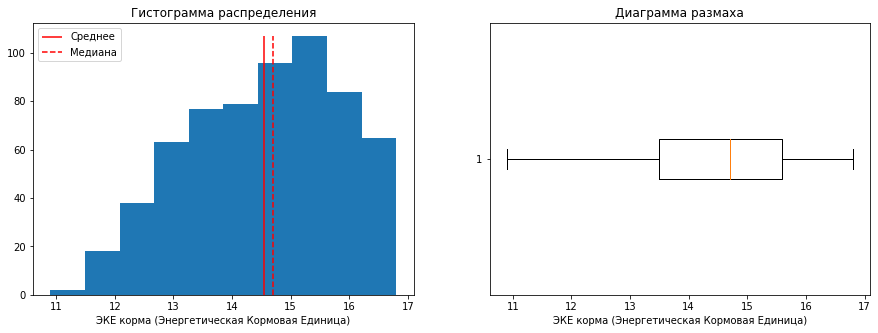

Статистический анализ показателя  Жирность молока (%)
--------------------------------------------------------------------------------------------------------------


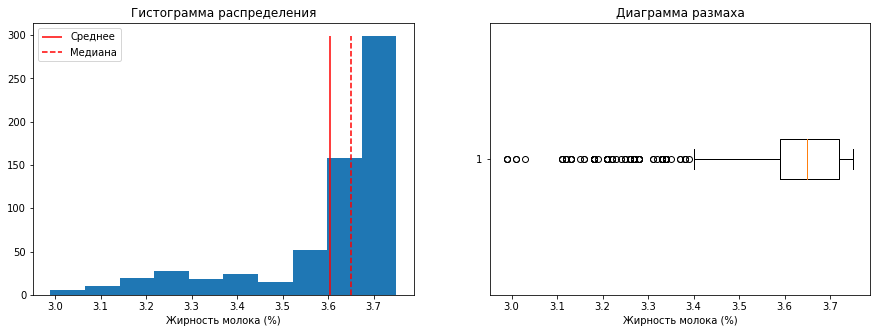

Статистический анализ показателя  Содержание белка в молоке (%)
--------------------------------------------------------------------------------------------------------------


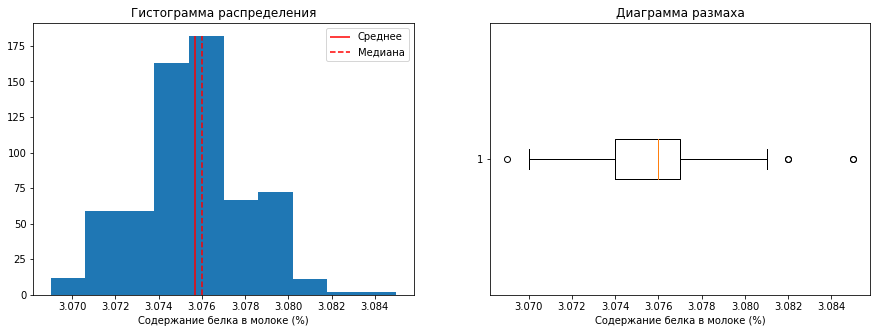

Статистический анализ показателя  Сырой протеин в корме (г)
--------------------------------------------------------------------------------------------------------------


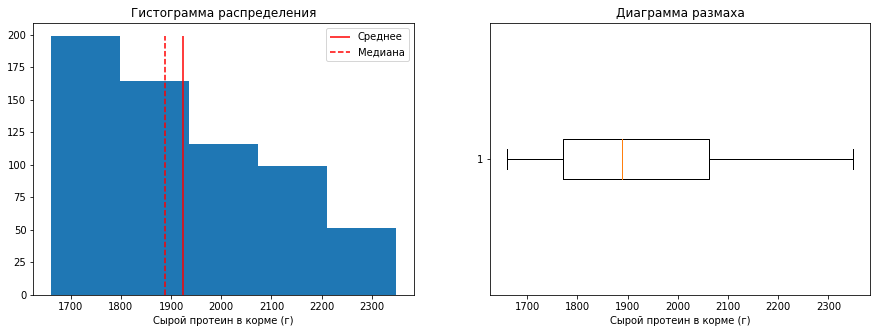

Статистический анализ показателя  СПО корма (Сахаро-протеиновое соотношение)
--------------------------------------------------------------------------------------------------------------


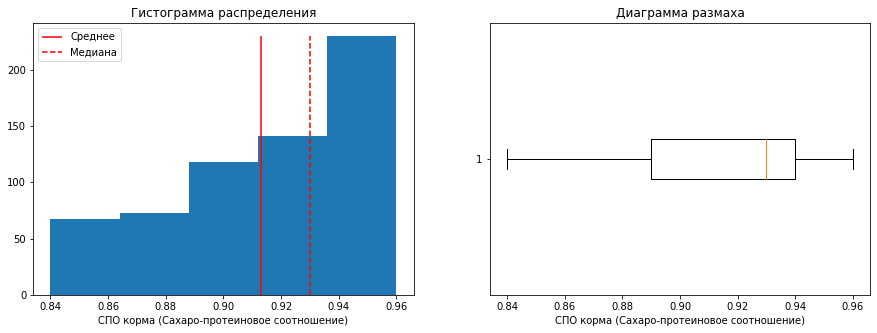

In [30]:
stat_plots(farm['meal_energy'])
stat_plots(farm['milk_fat'])
stat_plots(farm['milk_protein'])
stat_plots(farm['meal_protein'], nbins=5)
stat_plots(farm['meal_gpr'], nbins=5)

**Исследуем категориальные признаки**

Распределение долей по показателю  Порода коровы
--------------------------------------------------------------------------------------------------------------


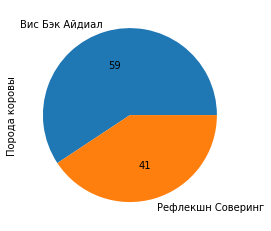

Распределение долей по показателю  Тип пастбища
--------------------------------------------------------------------------------------------------------------


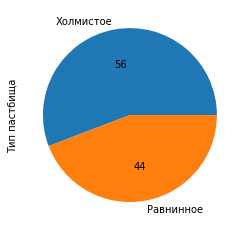

Распределение долей по показателю  Порода производителя
--------------------------------------------------------------------------------------------------------------


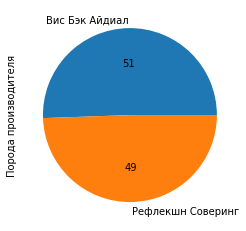

Распределение долей по показателю  Категория возраста
--------------------------------------------------------------------------------------------------------------


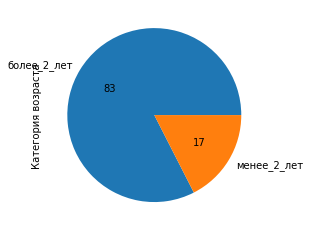

In [31]:
stat_plots(farm['race'])
stat_plots(farm['pasture_type'])
stat_plots(farm['dad_race'])
stat_plots(farm['age_category'])

### Результаты исследовательского анализа данных:

**Анализ количественных данных**\
В данных по удою был обнаружен и устранен один выброс, очень похожий на опечатку.\
После устранения выброса, анализ данных об удое показывает картину, близкую к нормальному распределению, но с искажениями в районе третьего квартиля.\
Похожая картина наблюдается в данных о ЭКЕ корма (Энергетическая Кормовая Единица).\
Распределение жирности молока показывает высокий уровень управляемости этим показателем со стороны производственного процесса - основная масса коров дает молоко жирностью в районе 3,6%, а жирность меньше 3,4% характеризуется как выбросы. Устранять эти выбросы мы не будем, поскольку нет повода усомниться в действительности этих данных.\
Содержание белка в молоке показывает картину нормального распределения - это говорит о том, что данный показатель не поддается регулировке со стороны производственного процесса на ферме. Судя по всему, информация об этом известна Заказчику, о чем говорят данные о содержании протеинов в кормах, по которым видно, что основная масса стада получает корма с низким содержанием белка.\
Данные о СПО корма (Сахаро-протеиновом соотношении), напротив, указывают на то, что руководство фермы стремится увеличить этот показатель, поскольку он очевидно оказывает прямое влияние на показатель жирности молока, который, в свою очередь, является одним из основных коммерческих показателей фермы.\
**Анализ категориальных данных**\
Данные о распределении стада по категориям не содержат каких-то явных аномалий, за исключением того, что основная часть поголовья находится в возрасте свыше 2-х лет.
Также непонятен дисбаланс между данными о породе коровы и породе производителя - очевидно он вызван какими-то ошибками в учете, поскольку сведений о наличии гибридных пород в данных не обнаружено.

## Корреляционный анализ

Построим матрицу корреляции данных в датасете заказчика

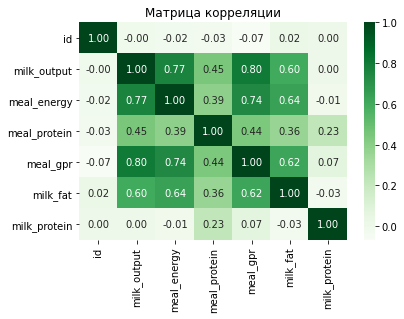

In [32]:
sns.heatmap(farm.corr(), annot=True, fmt='.2f', cmap='Greens')
plt.title('Матрица корреляции')
plt.show()

Мы можем наблюдать заметную прямую зависимость целевого признака от следующих входных признаков:
- meal_energy
- meal_gpr
- milk_fat

При этом, между всеми этими входными признаками мы также можем наблюдать заметную взаимосвязь.
Однако, значение коэффициента корреляции Пирсона этой связи ниже 0,9 - это значит что о мультиколлинеарности здесь нельзя утверждать.

Создадим функцию для построения диаграмм рассеяния для целевого признака и всех количественных признаков с учётом значений всех категориальных признаков

In [33]:
def corr_plots(dataset, target, num_ind, cat_ind, title, x_label):
    categories = dataset[cat_ind].unique()
    print(title)
    sns.scatterplot(data=dataset, x=num_ind, y=target, hue=cat_ind)
    plt.show()

Построим диаграммы рассеяния при помощи этой функции

Зависимость удоя от признака  ЭКЕ корма (Энергетическая Кормовая Единица) 
В разрезе значений признака  Порода коровы


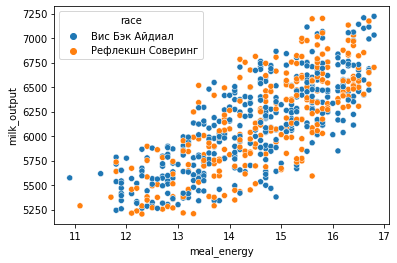

В разрезе значений признака  Порода производителя


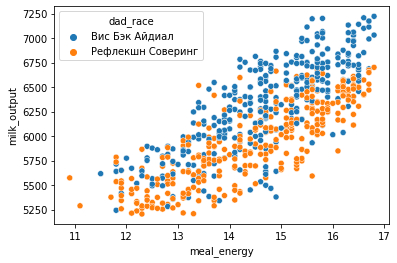

В разрезе значений признака  Тип пастбища


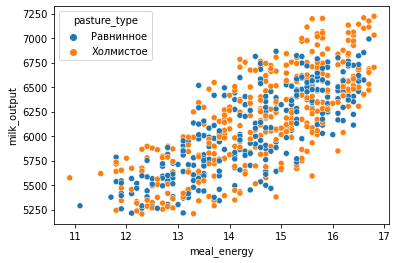

В разрезе значений признака  Категория возраста


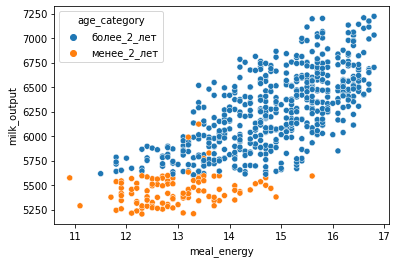

В разрезе значений признака  Вкус молока


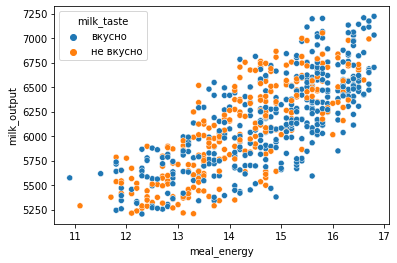

Зависимость удоя от признака  Сырой протеин в корме (г) 
В разрезе значений признака  Порода коровы


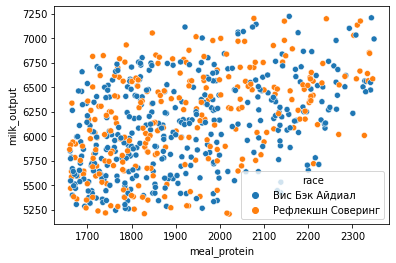

В разрезе значений признака  Порода производителя


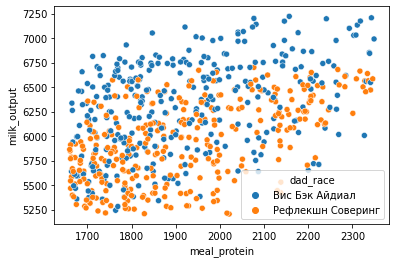

В разрезе значений признака  Тип пастбища


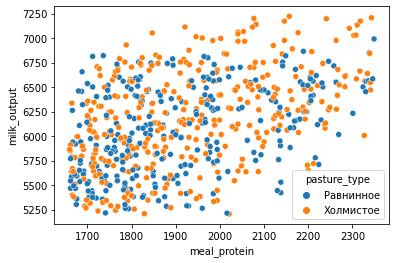

В разрезе значений признака  Категория возраста


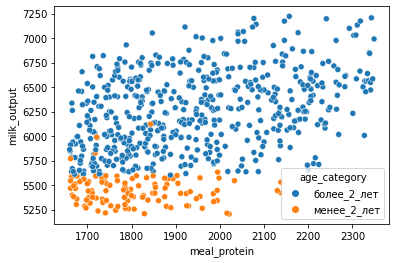

В разрезе значений признака  Вкус молока


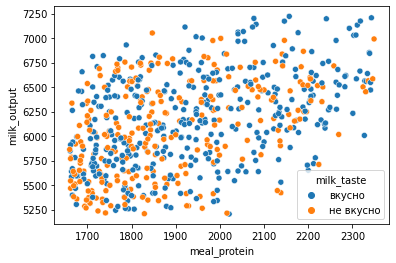

Зависимость удоя от признака  СПО корма (Сахаро-протеиновое соотношение) 
В разрезе значений признака  Порода коровы


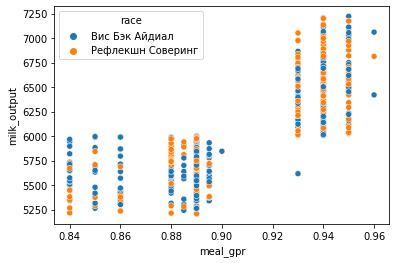

В разрезе значений признака  Порода производителя


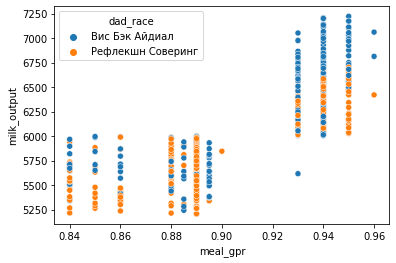

В разрезе значений признака  Тип пастбища


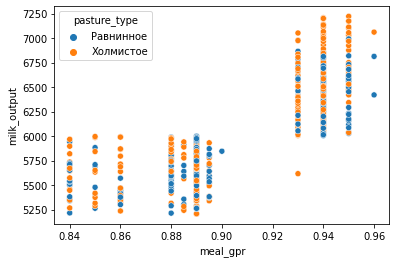

В разрезе значений признака  Категория возраста


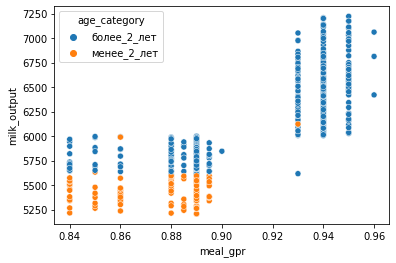

В разрезе значений признака  Вкус молока


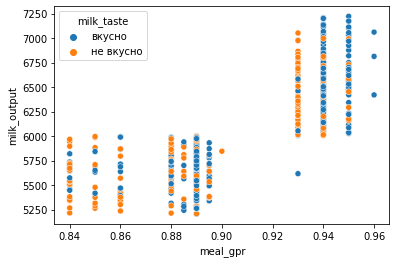

Зависимость удоя от признака  Жирность молока (%) 
В разрезе значений признака  Порода коровы


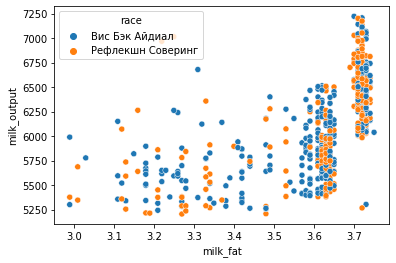

В разрезе значений признака  Порода производителя


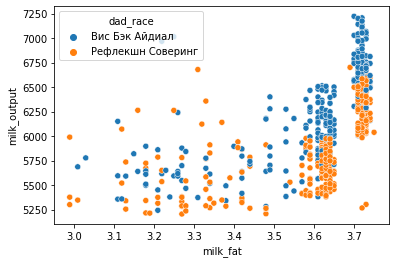

В разрезе значений признака  Тип пастбища


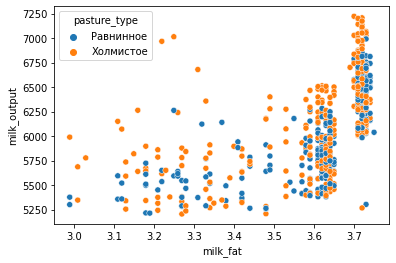

В разрезе значений признака  Категория возраста


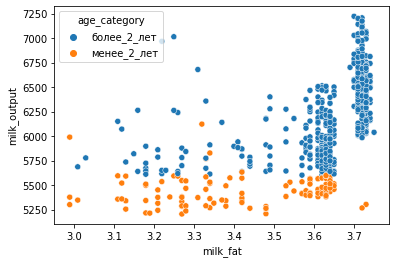

В разрезе значений признака  Вкус молока


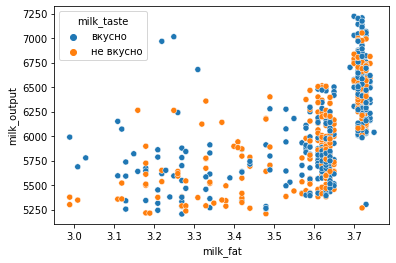

Зависимость удоя от признака  Содержание белка в молоке (%) 
В разрезе значений признака  Порода коровы


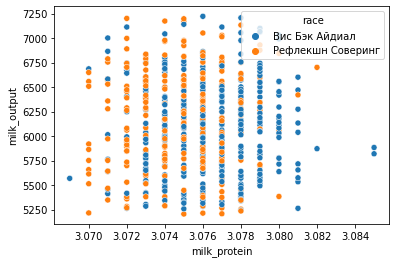

В разрезе значений признака  Порода производителя


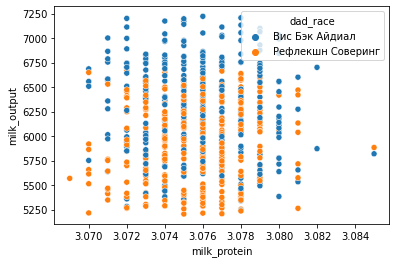

В разрезе значений признака  Тип пастбища


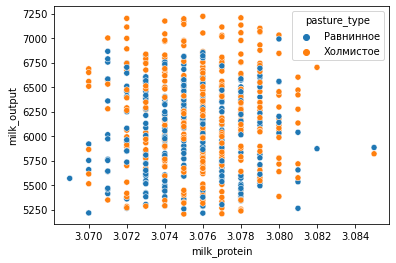

В разрезе значений признака  Категория возраста


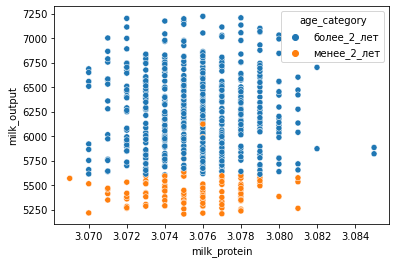

В разрезе значений признака  Вкус молока


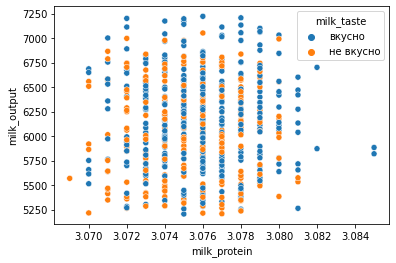

In [34]:
dataset = farm
target = 'milk_output'
for num_ind in ['meal_energy', 'meal_protein', 'meal_gpr', 'milk_fat', 'milk_protein']:
    print('=' * 120)
    print(f'Зависимость удоя от признака \033[1m {glossary[num_ind]} \033[0m')
    print('=' * 120)
    for cat_ind in ['race', 'dad_race', 'pasture_type', 'age_category', 'milk_taste']:
        title =  f'В разрезе значений признака \033[1m {glossary[cat_ind]}'
        x_label = glossary[num_ind]
        corr_plots(dataset, target, num_ind, cat_ind, title, x_label)

**Результаты корреляционного анализа**

Диаграммы разброса показывают прямую зависимость удоя от признака **ЭКЕ** (Энергетическая Кормовая Единица).\
Эта зависимость носит нелинейную связь, поскольку усиливается на высоких значениях ЭКЕ.

Видна также прямая зависимость удоя от показателя **СПО** (Сахаро-протеиновое соотношение), но эта зависимость сильно дискретная, и данные сгруппированы в два больших кластера:
- низкие удои с низким СПО
- высокие удои с высоким СПО
Граница между этими кластерами проходит в районе значения СПО 0,92.\

Похожую картину мы можем наблюдать также при анализе признака признака **Жирность молока**, но скорее всего это происходит в силу зависимости этого признака от признака **СПО**, которую мы отметили на предыдущем этапе.\

Из категориальных признаков зависимость удоя видна от следующих:
* Порода производителя
* Категория возраста

Остальные признаки не оказывают существенного влияния на целевой признак, что мы видели также на матрице корреляции.

Кроме того, на матрице корреляции мы наблюдали взаимную зависимость следующих входных признаков:
- meal_energy
- meal_gpr
- milk_fat

Однако, значение коэффициента корреляции Пирсона этой связи ниже 0,9 - это значит что о мультиколлинеарности здесь нельзя утверждать.

## Обучение модели линейной регрессии

### Модель 1

Сформируем датафрейм для моделирования

In [35]:
farm_output = farm.drop(['id', 'milk_fat', 'milk_protein', 'milk_taste'], axis=1)

Выделим целевой признак

In [36]:
X = farm_output.drop('milk_output', axis=1)
y = farm_output['milk_output']

Сформируем тренировочные и тестовые выборки для моделирования

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

Создадим списки названий колонок категориальных и количественных признаков

In [38]:
cat_col = ['race', 'pasture_type', 'dad_race', 'age_category']
num_col = ['meal_energy', 'meal_gpr', 'meal_protein']

Закодируем категориальные признаки числовыми значениями со сбросом дамми-ловушек и сохранением читабельности результатов, после чего прочитаем получившиеся названия закодированных колонок:

In [39]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col])
X_test_ohe = encoder.transform(X_test[cat_col])
encoder_col = encoder.get_feature_names()
encoder_col

array(['x0_Рефлекшн Соверинг', 'x1_Холмистое', 'x2_Рефлекшн Соверинг',
       'x3_менее_2_лет'], dtype=object)

Конвертируем полученный после кодировки список списков в датафрейм

In [40]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col).astype('int32')
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col).astype('int32')
X_train_ohe.head(3)

,x0_Рефлекшн Соверинг,x1_Холмистое,x2_Рефлекшн Соверинг,x3_менее_2_лет
0,1,1,0,0
1,1,0,0,0
2,1,1,1,0


Приведем количественные признаки к единому масштабу и конвертируем полученные результаты в датафрейм

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)
X_train_scaled.head(3)

,meal_energy,meal_gpr,meal_protein
0,0.661860,0.833384,0.447518
1,0.509979,0.523945,-0.579882
2,0.054336,0.523945,0.371010


Объединим датафреймы с обработанными признаками и перезапишем изначальные выборки

In [42]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis = 1)

Обучим модель линейной регрессии на подготовленных данных и получим прогнозные значения целевого признака

In [43]:
model_1  = LinearRegression()
model_1.fit(X_train, y_train)
predictions_1 = model_1.predict(X_test)

Вычислим коэффициент детерминации обученной модели

In [44]:
r2 = r2_score(y_test, predictions_1)
print(f'Коэффициент детерминации (R2) модели равен {r2:.2}')

Коэффициент детерминации (R2) модели равен 0.82


Вычислим значения ошибок полученного прогноза и построим графики для визуализации распределения и дисперсии остатков

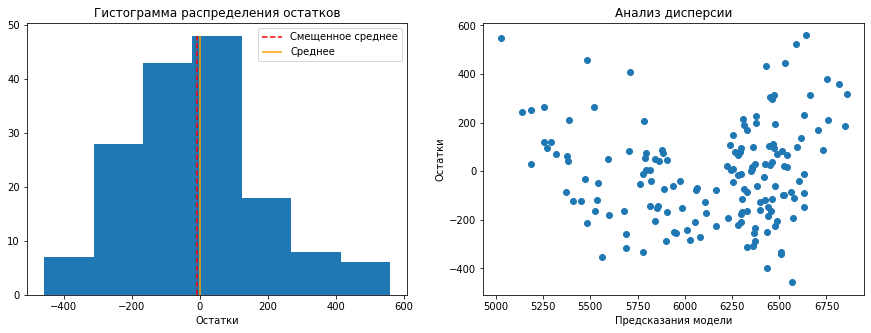

In [45]:
residuals = y_test - predictions_1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
bins = axes[0].hist(residuals, bins=7)
axes[0].vlines(x=residuals.mean(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Смещенное среднее')
axes[0].vlines(x=0, colors='orange', ymin=0, ymax=bins[0].max(), label='Среднее')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_1, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Распределение остатков нормальное, среднее значение соответствует нулевому отклонению.

Дисперсия остатков неравномерна - наблюдаются два условных центра, в зоне средних и высоких удоев. Форма дисперсии напоминает дугу. Необходимо выяснить, что может являться причиной этого. Похоже, есть еще какой-то признак, значение которого напрямую связано с высокими удоями, и этого признака нет в наших данных.

### Модель 2

Откалибруем полученную модель, исключив нелинейность связи с целевым следующих входных признаков:
- СПО
- ЭКЕ

Конвертируем в категориальные числовые значения признака СПО, установив в качестве порога значение 0.92, которое делит наблюдения на диаграмме рассеяния на два кластера: 

In [46]:
farm['gpr_level'] = farm['meal_gpr'].apply(lambda cell: 'high' if cell > 0.92 else 'low')

Возведем в квадрат значение признака ЭКЕ для устранения нелинейности связи с целевым признаком

In [47]:
farm['meal_energy_squared'] = farm['meal_energy'] ** 2

**Выполним все операции по подготовке данных и обучим Модель №2 на новых признаках:**

In [48]:
farm_output = farm.drop(['id', 'milk_fat', 'milk_protein', 'milk_taste', 'meal_gpr', 'meal_energy'], axis=1)

In [49]:
#выделим целевой признак
X = farm_output.drop('milk_output', axis=1)
y = farm_output['milk_output']

In [50]:
#сформируем тренировочные и тестовые выборки для моделирования
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [51]:
#создадим списки названий колонок категориальных и количественных признаков
cat_col = ['race', 'pasture_type', 'dad_race', 'age_category', 'gpr_level']
num_col = ['meal_energy_squared', 'meal_protein']

In [52]:
#закодируем категориальные признаки числовыми значениями
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col])
X_test_ohe = encoder.transform(X_test[cat_col])
#прочитаем названия закодированных колонок
encoder_col = encoder.get_feature_names()

In [53]:
#конвертируем полученный после кодировки список списков в датафрейм
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col).astype('int32')
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col).astype('int32')

In [54]:
#приведем количественные признаки к единому масштабу
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])
#конвертируем результаты в датафрейм
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

In [55]:
#объединим датафреймы с обработанными признаками и перезапишем изначальные выборки 
X_train = pd.concat([X_train_ohe, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis = 1)

In [56]:
model_2  = LinearRegression()
model_2.fit(X_train, y_train)
predictions_2 = model_2.predict(X_test)

In [57]:
#вычислим коэффициент детерминации
r2 = r2_score(y_test, predictions_2)
print(f'Коэффициент детерминации (R2) модели равен {r2:.2}')

Коэффициент детерминации (R2) модели равен 0.85


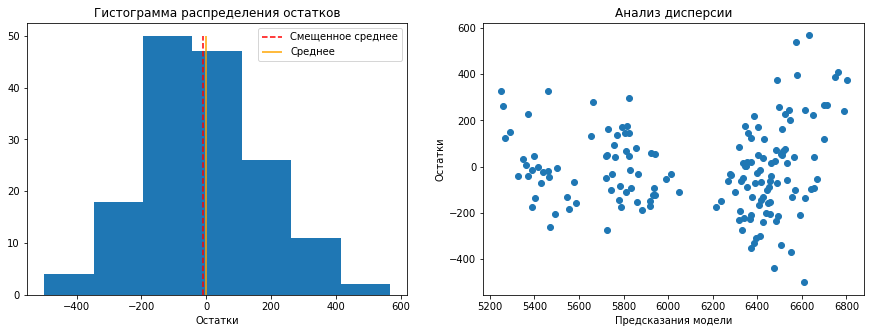

In [58]:
#вычислим значения ошибок полученного прогноза
residuals = y_test - predictions_2

#построим графики для визуализации распределения и дисперсии остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
bins = axes[0].hist(residuals, bins=7)
axes[0].vlines(x=residuals.mean(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Смещенное среднее')
axes[0].vlines(x=0, colors='orange', ymin=0, ymax=bins[0].max(), label='Среднее')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_2, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

После трансформации датасета в соответствии с инструкциями проекта, коэффициент детерминации модели незначительно увеличился, распределение остатков осталось практически прежним, только пик сместился в зону отрицательных значений.

Дисперсия остатков осталась неравномерной, но стала меньше похожа на дугу.

### Модель 3

Следующим шагом добавим в модель новые данные - имя отца коровы

In [59]:
m3_data = farm.merge(legacy, on='id')

Затем повторим калибровку, выполненную для Модели №2

In [60]:
m3_data['gpr_level'] = m3_data['meal_gpr'].apply(lambda cell: 'high' if cell > 0.92 else 'low')

In [61]:
m3_data['meal_energy_squared'] = m3_data['meal_energy'] ** 2

In [62]:
m3_data = m3_data.drop(['id', 'milk_taste', 'meal_gpr', 'meal_energy'], axis=1)

**Выполним все операции по подготовке данных и обучим Модель №3 на новых признаках:**

In [63]:
#выделим целевой признак
X = m3_data.drop('milk_output', axis=1)
y = m3_data['milk_output']

In [64]:
#сформируем тренировочные и тестовые выборки для моделирования
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [65]:
#создадим списки названий колонок категориальных и количественных признаков
cat_col = ['race', 'pasture_type', 'dad_race', 'age_category', 'gpr_level', 'dad_name']
num_col = ['meal_energy_squared', 'meal_protein']

In [66]:
#закодируем категориальные признаки числовыми значениями
m3_encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = m3_encoder.fit_transform(X_train[cat_col])
X_test_ohe = m3_encoder.transform(X_test[cat_col])
#прочитаем названия закодированных колонок
encoder_col = m3_encoder.get_feature_names()

In [67]:
#конвертируем полученный после кодировки список списков в датафрейм
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col).astype('int32')
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col).astype('int32')

In [68]:
#приведем количественные признаки к единому масштабу
m3_scaler = StandardScaler()
X_train_scaled = m3_scaler.fit_transform(X_train[num_col])
X_test_scaled = m3_scaler.transform(X_test[num_col])
#конвертируем результаты в датафрейм
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

In [69]:
#объединим датафреймы с обработанными признаками и перезапишем изначальные выборки 
X_train = pd.concat([X_train_ohe, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis = 1)

In [70]:
model_3  = LinearRegression()
model_3.fit(X_train, y_train)
predictions_3 = model_3.predict(X_test)

In [71]:
#вычислим коэффициент детерминации
r2 = r2_score(y_test, predictions_3)
print(f'Коэффициент детерминации (R2) модели равен {r2:.2}')

Коэффициент детерминации (R2) модели равен 0.85


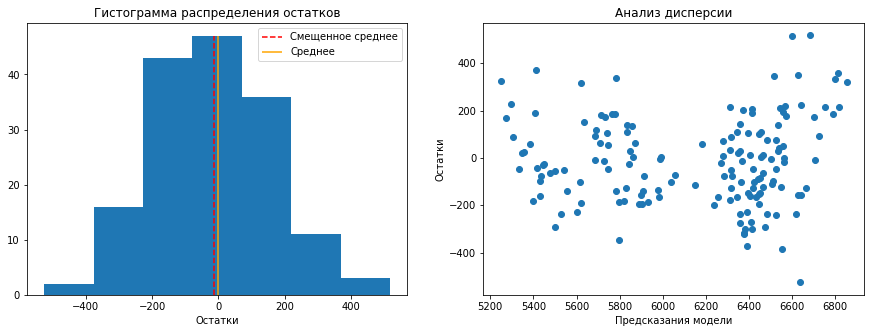

In [72]:
#вычислим значения ошибок полученного прогноза
residuals_m3 = y_test - predictions_3

residuals = residuals_m3
#построим графики для визуализации распределения и дисперсии остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
bins = axes[0].hist(residuals, bins=7)
axes[0].vlines(x=residuals.mean(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Смещенное среднее')
axes[0].vlines(x=0, colors='orange', ymin=0, ymax=bins[0].max(), label='Среднее')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_3, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Метрики модели вновь улучшились.

### Метрики моделей

Определим функцию для расчета всех метрик линейной регрессии

In [73]:
def metrics_lr(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred).astype('int')
    mse = mean_squared_error(y_true, y_pred).astype('int')
    rmse = mean_squared_error(y_true, y_pred, squared=False).astype('int')
    r2 = round(r2_score(y_true, y_pred), 3)
    return [mae, mse, rmse, r2]

Выполним сбор данных всех моделей и формирование таблицы результатов

In [74]:
predictions = [predictions_1, predictions_2, predictions_3]
results = pd.DataFrame(['MAE', 'MSE', 'RMSE', 'R2'], columns=['Метрика'])
for i in range(len(predictions)):
    y_true = y_test
    y_pred = predictions[i]
    column = f'Модель {i + 1}'
    results[column] = metrics_lr(y_true, y_pred)
results

,Метрика,Модель 1,Модель 2,Модель 3
0,MAE,160.000,146.000,148.00
1,MSE,40396.000,34703.000,34017.00
2,RMSE,200.000,186.000,184.00
3,R2,0.822,0.847,0.85


**Наилучшие показатели по метрикам показала Модель №3 - будем использовать ее для прогнозирования.**

Рассчитаем доверительный интервал прогноза этой модели путем расчета квантилей с шагом вероятности 5%:

In [75]:
statistics.quantiles(residuals_m3, n=20)

[-298.33963585737285,
 -237.5601743201537,
 -189.93040183567018,
 -165.16970377324415,
 -150.01470638451087,
 -126.65005581409059,
 -101.533833925206,
 -76.00153692129462,
 -48.378089021428785,
 -24.086016404688053,
 -2.3104361478694955,
 21.10600821508324,
 53.23546618117011,
 77.96129148981763,
 107.74332711124316,
 154.9751011017319,
 185.08791568098113,
 213.36094919892548,
 334.5350890939863]

Таким образом, мы можем утверждать, что доверительным интервалом выбранной модели с порогом значимости 5% является диапазон от -298 до 335. 

### Прогнозирование на рабочих данных

Добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) из датасета ferma_main.csv, взяв средние значения каждого из признаков и увелив их на 5%:

In [76]:
shop_predict = shop
shop_predict['meal_protein'] = round(m3_data['meal_protein'].mean() * 1.05, 0).astype('int32')
shop_predict['meal_energy_squared'] = m3_data['meal_energy_squared'].mean() * 1.05
shop_predict['meal_gpr'] = farm['meal_gpr'].mean() * 1.05
shop_predict['gpr_level'] = shop_predict['meal_gpr'].apply(lambda cell: 'high' if cell > 0.92 else 'low')
shop_predict.head()

,race,pasture_type,dad_race,dad_name,milk_fat,milk_protein,age_category,meal_protein,meal_energy_squared,meal_gpr,gpr_level
0,Вис Бэк Айдиал,Холмистое,Вис Бэк Айдиал,Геркулес,3.58,3.076,более_2_лет,2020,223.889829,0.958772,high
1,Вис Бэк Айдиал,Равнинное,Рефлекшн Соверинг,Буйный,3.54,3.081,менее_2_лет,2020,223.889829,0.958772,high
2,Рефлекшн Соверинг,Равнинное,Рефлекшн Соверинг,Барин,3.59,3.074,более_2_лет,2020,223.889829,0.958772,high
3,Рефлекшн Соверинг,Холмистое,Вис Бэк Айдиал,Буйный,3.40,3.061,более_2_лет,2020,223.889829,0.958772,high
4,Рефлекшн Соверинг,Равнинное,Вис Бэк Айдиал,Буйный,3.64,3.074,более_2_лет,2020,223.889829,0.958772,high


**Выполним подготовку данных как для тренировочной выборки**

In [77]:
#создадим списки названий колонок категориальных и количественных признаков
cat_col = ['race', 'pasture_type', 'dad_race', 'age_category', 'gpr_level', 'dad_name']
num_col = ['meal_energy_squared', 'meal_protein']

In [78]:
#закодируем категориальные признаки числовыми значениями
X_shop_ohe = m3_encoder.transform(shop_predict[cat_col])
#прочитаем названия закодированных колонок
encoder_col = m3_encoder.get_feature_names()
encoder_col

array(['x0_Рефлекшн Соверинг', 'x1_Холмистое', 'x2_Рефлекшн Соверинг',
       'x3_менее_2_лет', 'x4_low', 'x5_Буйный', 'x5_Геркулес',
       'x5_Соловчик'], dtype=object)

In [79]:
#конвертируем полученный после кодировки список списков в датафрейм
X_shop_ohe = pd.DataFrame(X_shop_ohe, columns=encoder_col).astype('int32')

In [80]:
#приведем количественные признаки к единому масштабу
X_shop_scaled = m3_scaler.transform(shop_predict[num_col])
#конвертируем результаты в датафрейм
X_shop_scaled = pd.DataFrame(X_shop_scaled, columns=num_col)

In [81]:
#объединим датафреймы с обработанными признаками и перезапишем изначальные выборки 
X_shop = pd.concat([X_shop_ohe, X_shop_scaled], axis = 1)

**Получим предсказания удоя для списка коров к продаже**

In [82]:
milk_output_pred = model_3.predict(X_shop)

In [83]:
shop['predicted_milk_output'] = milk_output_pred
shop['predicted_milk_output'] = round(shop_predict['predicted_milk_output'], 0).astype('int32')

In [84]:
shop.head()

,race,pasture_type,dad_race,dad_name,milk_fat,milk_protein,age_category,meal_protein,meal_energy_squared,meal_gpr,gpr_level,predicted_milk_output
0,Вис Бэк Айдиал,Холмистое,Вис Бэк Айдиал,Геркулес,3.58,3.076,более_2_лет,2020,223.889829,0.958772,high,6551
1,Вис Бэк Айдиал,Равнинное,Рефлекшн Соверинг,Буйный,3.54,3.081,менее_2_лет,2020,223.889829,0.958772,high,6284
2,Рефлекшн Соверинг,Равнинное,Рефлекшн Соверинг,Барин,3.59,3.074,более_2_лет,2020,223.889829,0.958772,high,6257
3,Рефлекшн Соверинг,Холмистое,Вис Бэк Айдиал,Буйный,3.40,3.061,более_2_лет,2020,223.889829,0.958772,high,6568
4,Рефлекшн Соверинг,Равнинное,Вис Бэк Айдиал,Буйный,3.64,3.074,более_2_лет,2020,223.889829,0.958772,high,6506


## Обучение модели логистической регрессии

Соберем датасет для прогнозирования вкуса молока

In [85]:
taste_data = farm.merge(legacy, on='id').drop(['id', 'milk_output'], axis=1)

Подготовим данные для обучения модели логистической регрессии

In [86]:
#выделим целевой признак
X = taste_data.drop('milk_taste', axis=1)
y = taste_data['milk_taste'].replace({'вкусно': 1, 'не вкусно': 0})

In [87]:
#сформируем тренировочные и тестовые выборки для моделирования
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [88]:
#создадим списки названий колонок категориальных и количественных признаков
cat_col = ['race', 'pasture_type', 'dad_race', 'age_category', 'dad_name']
num_col = ['meal_energy_squared', 'meal_protein', 'milk_fat', 'milk_protein', 'meal_gpr']

In [89]:
#закодируем категориальные признаки числовыми значениями
encoder_taste = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_taste.fit_transform(X_train[cat_col])
X_test_ohe = encoder_taste.transform(X_test[cat_col])
shop_ohe = encoder_taste.transform(shop[cat_col])
#прочитаем названия закодированных колонок
encoder_col = encoder_taste.get_feature_names()
encoder_col

array(['x0_Рефлекшн Соверинг', 'x1_Холмистое', 'x2_Рефлекшн Соверинг',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [90]:
#конвертируем полученный после кодировки список списков в датафрейм
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col).astype('int32')
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col).astype('int32')
shop_ohe = pd.DataFrame(shop_ohe, columns=encoder_col).astype('int32')

In [91]:
#приведем количественные признаки к единому масштабу
scaler_taste = StandardScaler()
X_train_scaled = scaler_taste.fit_transform(X_train[num_col])
X_test_scaled = scaler_taste.transform(X_test[num_col])
shop_scaled = scaler_taste.transform(shop[num_col])
#конвертируем результаты в датафрейм
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)
shop_scaled = pd.DataFrame(shop_scaled, columns=num_col)

In [92]:
#объединим датафреймы с обработанными признаками и перезапишем изначальные выборки 
X_train = pd.concat([X_train_ohe, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis = 1)
shop_source = pd.concat([shop_ohe, shop_scaled], axis = 1)

**Обучим модель и получим набор прогнозных значений**

In [93]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Определим функцию для расчета метрик логистической регрессии

In [94]:
def metrics_logreg(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred), 2)
    precision = round(precision_score(y_true, y_pred), 2)
    recall = round(recall_score(y_true, y_pred), 2)
    report = pd.DataFrame({'Метрика': ['Accuracy', 'Precision', 'Recall'], 'Значение': [accuracy, precision, recall]})
    return report

Вычислим метрики для обученной модели

In [95]:
metrics_logreg(y_test, y_pred)

,Метрика,Значение
0,Accuracy,0.65
1,Precision,0.67
2,Recall,0.81


Построим матрицу ошибок

Text(0.5, 15.0, 'Предсказание')

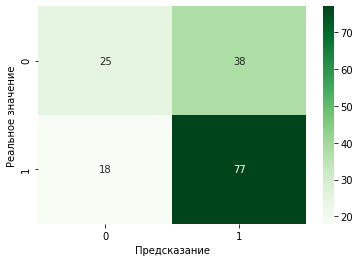

In [96]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.ylabel('Реальное значение')
plt.xlabel('Предсказание')

Поскольку для Заказчика важнее всего получить всех коров, которые дают вкусное молоко, нам необходимо добиться того, чтобы модель не давала ошибок False Negative, то есть максимизировать метрику Recall.

Для этого построим таблицу вероятностей присвоения категории, которую использует наша модель для категоризации:

In [97]:
y_proba = clf.predict_proba(X_test)[:,1]
proba_table = pd.DataFrame(zip(y_proba, y_pred), columns = ['y_proba', 'y_pred'])
proba_table.head(10)

,y_proba,y_pred
0,0.394193,0
1,0.266242,0
2,0.494682,0
3,0.674789,1
4,0.726247,1
5,0.816854,1
6,0.371140,0
7,0.721549,1
8,0.752091,1
9,0.496488,0


Определим функцию перерасчета прогноза логистической регрессии с новым порогом классификации

In [98]:
def reclassify(source, custom_threshold):
    y_proba = clf.predict_proba(source)[:,1]
    y_pred_new = []
    for i in range(len(y_proba)):
        reclassify = lambda item: 1 if item >= custom_threshold else 0
        y_pred_new.append(reclassify(y_proba[i]))
    return y_pred_new

Определим функцию подбора порога классификации для минимизации ошибок False Negative

In [99]:
def recall_tuning(source, y_true, recall_target=1):
    target = []
    thresholds = [round(i,2) for i in np.linspace(0.1, 1, num = 99, endpoint=False)]
    for t in range(len(thresholds)):
        tuned_predictions = reclassify(source, thresholds[t])
        recall = round(recall_score(y_true, tuned_predictions), 2)
        if recall < recall_target:
            try:
                return thresholds[t-1]
            except:
                return thresholds[t]
        else: continue
    return thresholds[t]

Получим оптимальное значение порога классификации и скорректируем прогноз модели с учетом нового порога.

In [100]:
optimized_threshold = recall_tuning(X_test, y_test)
tuned_predictions = reclassify(X_test, optimized_threshold)

Вычислим метрики полученного прогноза и построим матрицу ошибок для контроля максимизации метрики Recall

,Метрика,Значение
0,Accuracy,0.61
1,Precision,0.61
2,Recall,1.00


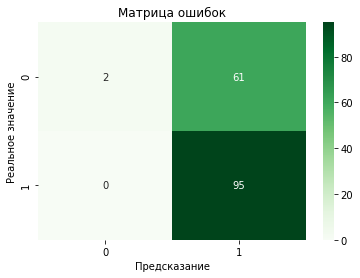

In [101]:
display(metrics_logreg(y_test, tuned_predictions))
cm = confusion_matrix(y_test, tuned_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.ylabel('Реальное значение')
plt.xlabel('Предсказание')
plt.title('Матрица ошибок')
plt.show()

**Получим предсказания модели на рабочих данных**

In [102]:
shop_pred = clf.predict(shop_source)
shop_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1])

Откалибруем предсказания по оптимизированному порогу классификации:

In [103]:
tuned_shop_predictions = reclassify(shop_source, optimized_threshold)
tuned_shop_predictions

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]

Переведем предсказания модели  в читабельный формат

In [104]:
shop['predicted_milk_taste'] = pd.Series(tuned_shop_predictions)
shop['predicted_milk_taste'] = shop['predicted_milk_taste'].replace({1: 'вкусно', 0: 'не вкусно'})
shop['predicted_milk_taste']

0        вкусно
1        вкусно
2        вкусно
3        вкусно
4        вкусно
5     не вкусно
6        вкусно
7        вкусно
8        вкусно
9        вкусно
10    не вкусно
11       вкусно
12       вкусно
13       вкусно
14    не вкусно
15       вкусно
Name: predicted_milk_taste, dtype: object

## Итоговые выводы

***Состояние данных***\
Данные в хорошем состоянии, отсутствуют пропуски и нулевые значения, присутствовало незначительное количество задублированных строк.\
В числовых полях использовался символ "," для разделения целой и дробной части числа. В результате, данные были импортированы в неверном формате. Желательно в дальнейшем заменить этот разделитель на точку.\
Названия пород во всех таблицах назывались по-разному и были приведены к единому стандарту.

***Статистический анализ данных***\
Анализ данных об удое показывает картину, близкую к нормальному распределению, но с искажениями в районе третьего квартиля.
Похожая картина наблюдается в данных о ЭКЕ корма (Энергетическая Кормовая Единица).\
Распределение жирности молока показывает высокий уровень управляемости этим показателем со стороны производственного процесса - основная масса коров дает молоко жирностью в районе 3,6%, а жирность меньше 3,4% характеризуется как выбросы.\
Содержание белка в молоке показывает картину нормального распределения - это говорит о том, что данный показатель не поддается регулировке со стороны производственного процесса на ферме. Судя по всему, информация об этом известна Заказчику, о чем говорят данные о содержании протеинов в кормах, по которым видно, что основная масса стада получает корма с низким содержанием белка.\
Данные о СПО корма (Сахаро-протеиновом соотношении), напротив, указывают на то, что руководство фермы стремится увеличить этот показатель, поскольку он очевидно оказывает прямое влияние на показатель жирности молока, который, в свою очередь, является одним из основных коммерческих показателей фермы.\
Основная часть поголовья находится в возрасте свыше 2-х лет.\
По неизвестным причинам в 291 записи из данных фермы порода коровы не соответствовала породе производителя.\

***Корреляционный анализ показателей***\
Целевой признак "Удой" имеет прямую зависимость от признаков ЭКЕ (Энергетическая Кормовая Единица) и СПО (Сахаро-протеиновое соотношение).\
Эта зависимость не является линейной, что может снизить качество обучения моделей.\
Из категориальных признаков зависимость удоя видна от следующих:
- Порода производителя
- Категория возраста

Остальные признаки не оказывают существенного влияния на целевой признак, что мы видели также на матрице корреляции.\
Кроме того, наблюдается взаимная зависимость следующих признаков ЭКЕ, СПО и Жирность молока, которая недостаточно сильна для того, чтобы утверждать о наличии мультиколлинеарности.\

***Прогнозирование целевого показателя "Удой"***\
Для прогнозирования показателя "Удой" была применена модель линейной регрессии.\
В процессе калибровки модели были улучшены следующие показатели:
- Средняя ошибка сокращена со 160 до 148 литров
- Среднеквадратичная ошибка сокращена с 200 до 184 литров
- Коэффициент детерминации вырос с 0,82 до 0,85\
Доверительный интервал итоговой модели логистической регрессии выглядит как диапазон от -298 до 335 литров, что говорит о том, что ошибка в предсказанниях значений удоя приобретамых животных с вероятностью 95% будет находиться в пределах этого интервала.\

***Прогнозирование целевого показателя "Вкус молока"***\
Для прогнозирования показателя "Вкус молока" была применена модель логистической регрессии.\
Обученная модель способна предсказать вкус молока у покупаемых коров с точностью 65%.\
В соответствии с требованиями Заказчика, модель была дополнительно откалибрована с целью полного исключения ошибочных предсказаний получения вкусного молока.\
В результате этой калибровки точность прогнозирования сократилась всего на 4%.\

***Способы улучшения качества прогнозирования***\
Получаемые прогнозы можно сделать более точными, если добавить в исходные данные дополнительные данные о показателях, имеющих прямую линейную связь с целевыми показателями.

**Итоговые рекомендации по покупке**

In [105]:
order = shop.query('(predicted_milk_output >= @TARGET_OUTPUT & predicted_milk_taste == @TARGET_TASTE)')
print(f'Для обеспечения годового удоя с коровы не ниже {TARGET_OUTPUT} литров вкусного молока, \n'
      f'из предложенных {len(shop)} коров рекомендуется к покупке {len(order)}, а именно :')
order[['race', 'dad_name', 'age_category', 'predicted_milk_output', 'predicted_milk_taste']].sort_values(by='predicted_milk_output', ascending=False)

Для обеспечения годового удоя с коровы не ниже 6000 литров вкусного молока, 
из предложенных 16 коров рекомендуется к покупке 13, а именно :


,race,dad_name,age_category,predicted_milk_output,predicted_milk_taste
9,Рефлекшн Соверинг,Геркулес,более_2_лет,6570,вкусно
3,Рефлекшн Соверинг,Буйный,более_2_лет,6568,вкусно
12,Рефлекшн Соверинг,Буйный,более_2_лет,6568,вкусно
0,Вис Бэк Айдиал,Геркулес,более_2_лет,6551,вкусно
4,Рефлекшн Соверинг,Буйный,более_2_лет,6506,вкусно
6,Вис Бэк Айдиал,Буйный,более_2_лет,6494,вкусно
15,Вис Бэк Айдиал,Буйный,более_2_лет,6494,вкусно
7,Рефлекшн Соверинг,Буйный,менее_2_лет,6359,вкусно
8,Вис Бэк Айдиал,Соловчик,более_2_лет,6328,вкусно
13,Вис Бэк Айдиал,Соловчик,более_2_лет,6328,вкусно
